# Unit 5 - Financial Planning

In [118]:
'''
By Ying Fu
1. To visualize the savings composed by investments in shares and cryptocurrencies to assess if have enough money as an emergency fund.
2. Use the Alpaca API to fetch historical closing prices for a retirement portfolio composed of SPY and AGG, then run Monte Carlo simulations to project the portfolio performance at 30 years. 
3. Use the Monte Carlo data to calculate the expected portfolio returns given a specific initial investment amount.
4. Adjusting the portfolio to include more risk and to have a larger initial investment and rerun the retirement analysis to see what it would take to retire in 5 or 10 years

'''

'\nBy Ying Fu\n1. To visualize the savings composed by investments in shares and cryptocurrencies to assess if have enough money as an emergency fund.\n2. Use the Alpaca API to fetch historical closing prices for a retirement portfolio composed of SPY and AGG, then run Monte Carlo simulations to project the portfolio performance at 30 years. \n3. Use the Monte Carlo data to calculate the expected portfolio returns given a specific initial investment amount.\n4. Adjusting the portfolio to include more risk and to have a larger initial investment and rerun the retirement analysis to see what it would take to retire in 5 or 10 years\n\n'

In [119]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api import REST, TimeFrame
from MCForecastTools import MCSimulation
import datetime
from alpaca_functions import get_company


%matplotlib inline

In [120]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [121]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [122]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [123]:
# Fetch current BTC price
btc_price = requests.get(btc_url).json()
btc_price = btc_price['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
eth_price = requests.get(eth_url).json()
eth_price = eth_price['data']['1027']['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = btc_price * my_btc
my_eth_value = eth_price * my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $49449.60
The current value of your 5.3 ETH is $15466.46


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [124]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [125]:
# Set Alpaca API key and secret
alpaca_key = os.getenv("ALPACA_KEY_ID")
secret_key = os.getenv("ALPACA_SECRET_KEY")

#Verfy that Alpaca key and secret were correctly loaded
print(type(alpaca_key))
print(type(secret_key))

# Create the Alpaca API object
alpaca = REST(alpaca_key,secret_key)

<class 'str'>
<class 'str'>


In [126]:
# Format current date as ISO format
today = pd.Timestamp(datetime.date.today(),tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = TimeFrame.Day

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_current_price = alpaca.get_bars(tickers, timeframe,start=today,end=today, limit= 1000).df

df_current_price.index = df_current_price.index.date

# Preview DataFrame
df_current_price

,open,high,low,close,volume,trade_count,vwap,symbol
2022-03-21,107.60,107.649,106.9841,107.04,7583660,27308,107.310150,AGG
2022-03-21,444.45,446.460,440.6800,444.39,84975628,910025,443.793054,SPY


In [127]:
# Pick AGG and SPY close prices
agg_close_price = df_current_price.iloc[0,3]
spy_close_price = df_current_price.iloc[1,3]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $107.04
Current SPY closing price: $444.39


In [128]:
# Compute the current value of shares
my_spy_value = spy_close_price * my_spy
my_agg_value = agg_close_price * my_agg

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $22219.50
The current value of your 200 AGG shares is $21408.00


### Savings Health Analysis

In [129]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
asset =[ my_btc_value + my_eth_value, my_spy_value + my_agg_value]

# Create savings DataFrame
df_savings = pd.DataFrame(asset)
df_savings.columns=['amount']
df_savings.index = ['crypto','shares']

# Display savings DataFrame
df_savings

,amount
crypto,64916.06
shares,43627.50


<AxesSubplot:ylabel='amount'>

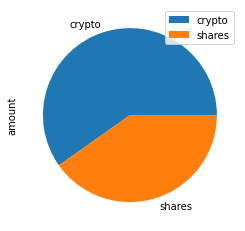

In [130]:
# Plot savings pie chart
df_savings.plot.pie(y='amount')

In [131]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings.sum().item()

# Validate saving health
if total_savings > emergency_fund:
    print(f'Congratulations! Your total_savings is ${total_savings}, and you have enough money in this fund!')
elif total_savings == emergency_fund:
    print(f"Congratuations! Your total_savings is ${total_savings}, and you are on reaching this financial goal!")
else:
    print(f"Sorry!You have ${emergency_fund}-{total_savings} away from reaching the goal!")

Congratulations! Your total_savings is $108543.56, and you have enough money in this fund!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [132]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp("2017-3/17", tz='America/New_York').isoformat()
today = pd.Timestamp(datetime.date.today(),tz="America/New_York").isoformat()


In [133]:
# Get 5 years' worth of historical data for SPY and AGG
# Use the defined function get_company() to get alpaca data for both AGG and SPY.
my_df = {
    "AGG":get_company("AGG", timeframe, "2017-03-17", "2022-03-18", alpaca),
    "SPY":get_company("SPY", timeframe, "2017-03-17", "2022-03-18", alpaca)
}

# Combined two dataframes into one dateframe. 
df_portfolio = pd.concat(my_df.values(), keys=my_df.keys(), axis="columns")

# Display data
df_portfolio.head()

AGG                                     \
                             open    high       low   close   volume   
timestamp                                                              
2017-03-17 04:00:00+00:00  107.72  107.91  107.6901  107.88  2368799   
2017-03-20 04:00:00+00:00  107.86  108.05  107.8401  108.05  1635249   
2017-03-21 04:00:00+00:00  107.93  108.27  107.9300  108.27  2049680   
2017-03-22 04:00:00+00:00  108.44  108.54  108.3600  108.42  2643641   
2017-03-23 04:00:00+00:00  108.44  108.51  108.2635  108.45  2071485   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2017-03-17 04:00:00+00:00       10846  107.859402  237.79  237.97  237.03   
2017-03-20 04:00:00+00:00        8198  107.961544  237.03  237.36  236.32   
2017-03-21 04:00:00+00:00       12024  108.175725  237.49  237.61  233.58   
2017-03-22 04:00:00+00:00       11111  108.455049  233.78  234.61  233.05   
2017-03-23 04:00:00+00:00       10901  108.417635  234.01  235.34  233.60   

                                                                        
                              close     volume trade_count        vwap  
timestamp                                                               
2017-03-17 04:00:00+00:00  237.1008   89002111      225269  237.526209  
2017-03-20 04:00:00+00:00  236.7400   52536979      169612  236.909398  
2017-03-21 04:00:00+00:00  233.7600  131809275      443599  234.853857  
2017-03-22 04:00:00+00:00  234.2500   97569204      307469  233.932509  
2017-03-23 04:00:00+00:00  233.9400  100410277      333903  234.388790

##### ---Note--- Another way to get corretct data frame for simulations. 

In [134]:
# # Get 5 years' worth of historical data for SPY and AGG
# # (use a limit=1000 parameter to call the most recent 1000 days of data)
# # set limit =3000 to get 5 year's data for both SPY and AGG. It works!!!
# df_tickers_data = alpaca.get_bars(
#     tickers,
#     timeframe,
#     start= start_date,
#     end= today,
#     limit=3000

# ).df

# # Display sample data
# df_tickers_data


In [135]:
# # Transform the data frame to the format that can be used to run simulations 
# df = df_tickers_data.groupby('symbol')
# # Retrieve AGG data
# df_tickers_data_AGG = df.get_group('AGG')
# df_tickers_data_AGG= df_tickers_data_AGG.drop(columns='symbol')
# df_tickers_data_AGG.columns = pd.MultiIndex.from_product([['AGG'],df_tickers_data_AGG.columns])

# # Retrieve SPY data
# df_tickers_data_SPY = df.get_group('SPY')
# df_tickers_data_SPY = df_tickers_data_SPY.drop(columns='symbol')
# df_tickers_data_SPY.columns = pd.MultiIndex.from_product([['SPY'],df_tickers_data_SPY.columns])

# # Combine AGG and SPY data
# df_portfolio = pd.concat([df_tickers_data_AGG,df_tickers_data_SPY],axis='columns',join='inner')
# df_portfolio

In [136]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30_year_sim = MCSimulation(
    portfolio_data = df_portfolio,
    weights=[.4,.6],
    num_simulation = 500,
    num_trading_days = 252*30)

In [137]:
# Printing the simulation input data
MC_30_year_sim.portfolio_data

AGG                                       \
                             open     high       low   close    volume   
timestamp                                                                
2017-03-17 04:00:00+00:00  107.72  107.910  107.6901  107.88   2368799   
2017-03-20 04:00:00+00:00  107.86  108.050  107.8401  108.05   1635249   
2017-03-21 04:00:00+00:00  107.93  108.270  107.9300  108.27   2049680   
2017-03-22 04:00:00+00:00  108.44  108.540  108.3600  108.42   2643641   
2017-03-23 04:00:00+00:00  108.44  108.510  108.2635  108.45   2071485   
...                           ...      ...       ...     ...       ...   
2022-03-14 04:00:00+00:00  107.78  107.816  107.3600  107.36   9492508   
2022-03-15 04:00:00+00:00  107.83  107.920  107.4300  107.60  13841071   
2022-03-16 04:00:00+00:00  107.63  107.730  107.0032  107.68  15809171   
2022-03-17 04:00:00+00:00  107.87  108.060  107.7300  107.86   8005258   
2022-03-18 04:00:00+00:00  107.95  108.140  107.9203  108.10   7800354   

                                                                    SPY  \
                          trade_count        vwap daily_return     open   
timestamp                                                                 
2017-03-17 04:00:00+00:00       10846  107.859402          NaN  237.790   
2017-03-20 04:00:00+00:00        8198  107.961544     0.001576  237.030   
2017-03-21 04:00:00+00:00       12024  108.175725     0.002036  237.490   
2017-03-22 04:00:00+00:00       11111  108.455049     0.001385  233.780   
2017-03-23 04:00:00+00:00       10901  108.417635     0.000277  234.010   
...                               ...         ...          ...      ...   
2022-03-14 04:00:00+00:00       34364  107.571987    -0.009685  420.975   
2022-03-15 04:00:00+00:00       33852  107.622094     0.002235  419.900   
2022-03-16 04:00:00+00:00       43366  107.553629     0.000743  429.940   
2022-03-17 04:00:00+00:00       24093  107.889900     0.001672  433.700   
2022-03-18 04:00:00+00:00       23567  108.060585     0.002225  438.200   

                                                                            \
                             high     low     close     volume trade_count   
timestamp                                                                    
2017-03-17 04:00:00+00:00  237.97  237.03  237.1008   89002111      225269   
2017-03-20 04:00:00+00:00  237.36  236.32  236.7400   52536979      169612   
2017-03-21 04:00:00+00:00  237.61  233.58  233.7600  131809275      443599   
2017-03-22 04:00:00+00:00  234.61  233.05  234.2500   97569204      307469   
2017-03-23 04:00:00+00:00  235.34  233.60  233.9400  100410277      333903   
...                           ...     ...       ...        ...         ...   
2022-03-14 04:00:00+00:00  424.55  415.79  417.0000   91930409      863515   
2022-03-15 04:00:00+00:00  426.84  418.42  426.1700  104219651      920659   
2022-03-16 04:00:00+00:00  435.68  424.80  435.6200  138130298     1344164   
2022-03-17 04:00:00+00:00  441.07  433.19  441.0700  100157174      784018   
2022-03-18 04:00:00+00:00  444.86  437.22  444.5200  102327793      790235   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-03-17 04:00:00+00:00  237.526209          NaN  
2017-03-20 04:00:00+00:00  236.909398    -0.001522  
2017-03-21 04:00:00+00:00  234.853857    -0.012588  
2017-03-22 04:00:00+00:00  233.932509     0.002096  
2017-03-23 04:00:00+00:00  234.388790    -0.001323  
...                               ...          ...  
2022-03-14 04:00:00+00:00  419.203845    -0.007308  
2022-03-15 04:00:00+00:00  422.752423     0.021990  
2022-03-16 04:00:00+00:00  431.339744     0.022174  
2022-03-17 04:00:00+00:00  437.706981     0.012511  
2022-03-18 04:00:00+00:00  441.458916     0.007822  

[1261 rows x 16 columns]

In [138]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30_year_sim.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.994173,1.001625,1.011470,0.997408,0.995719,0.993182,1.001478,0.999725,1.003396,0.995663,...,1.007657,1.014688,1.004773,1.009306,1.022520,0.995027,1.003551,0.987724,0.997698,1.003742
2,1.000760,1.008856,1.006806,1.001831,1.002416,0.995868,1.003379,0.997323,0.995251,1.007448,...,1.005897,1.007226,1.006342,0.996859,1.015433,0.989499,0.998819,0.986862,0.989971,1.002424
3,1.008453,1.014657,1.013471,1.002172,1.014408,0.995687,1.004643,0.991019,0.998570,1.007603,...,0.997970,0.991238,0.993548,1.005798,1.008551,1.001256,0.997623,0.975259,0.991947,1.005460
4,1.009380,1.028418,1.004546,1.004162,1.002601,1.007907,1.008813,0.999630,0.994940,1.008354,...,0.985938,0.985141,1.001447,1.003605,1.008029,1.004075,1.005769,0.977337,0.988600,1.008838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,5.664642,7.552316,12.708519,12.436116,40.569543,8.568232,21.081578,5.182471,10.764920,5.708953,...,6.165434,7.562403,13.833902,7.515740,11.481915,19.015433,8.863013,39.560895,18.471285,7.165672
7557,5.650688,7.642294,12.690400,12.528247,40.402509,8.544564,21.256207,5.176204,10.691025,5.686734,...,6.149471,7.594041,13.729274,7.563939,11.522680,18.992295,8.846535,39.366748,18.526795,7.107862
7558,5.635452,7.780368,12.572770,12.512511,40.635622,8.499383,21.502950,5.177152,10.688324,5.696669,...,6.176374,7.542649,13.661947,7.638003,11.536262,19.096648,8.874826,39.406125,18.628765,7.077412
7559,5.640978,7.739305,12.592347,12.426380,40.727098,8.575320,21.619990,5.088224,10.541072,5.644765,...,6.155684,7.592217,13.751099,7.574795,11.518949,19.064776,8.862344,39.428992,18.489309,7.065757


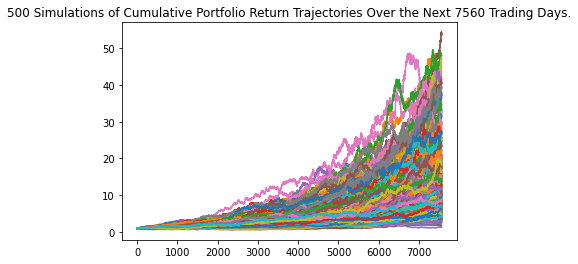

In [139]:
# Plot simulation outcomes
line_plot_30 = MC_30_year_sim.plot_simulation()
# Save the plot
line_plot_30.get_figure().savefig("MC_30_year_sim_plot.png", bbox_inches="tight")

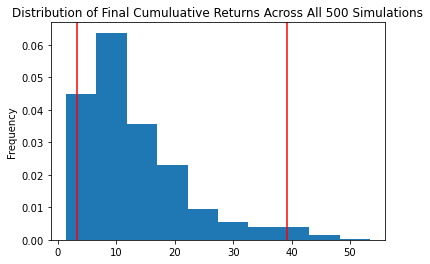

In [140]:
# Plot probability distribution and confidence intervals
dist_plot_30 = MC_30_year_sim.plot_distribution()
# Save the plot
dist_plot_30.get_figure().savefig("MC_30_year__dist_plot.png", bbox_inches="tight")

### Retirement Analysis

In [141]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_30 = MC_30_year_sim.summarize_cumulative_return()

# Print summary statistics
print(tbl_30)

count           500.000000
mean             13.074845
std               8.955141
min               1.357773
25%               6.701955
50%              10.617947
75%              16.721951
max              53.448950
95% CI Lower      3.248453
95% CI Upper     39.239615
Name: 7560, dtype: float64


c:\Users\yingf\Documents\homework\Financial-Planner\MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [142]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl_30[8]*initial_investment,2)
ci_upper = round(tbl_30[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $64969.06 and $784792.3


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [143]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl_30[8]*initial_investment,2)
ci_upper = round(tbl_30[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $97453.6 and $1177188.45


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [144]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# change the weight for AGG to 0.2, SPY to 0.8
MC_5_year_sim = MCSimulation(
    portfolio_data = df_portfolio,
    weights=[.2,.8],
    num_simulation = 500,
    num_trading_days = 252*5)

In [145]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_sim.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.991534,1.014163,1.009989,1.003997,0.998880,0.997372,0.982844,0.998097,1.004888,1.002139,...,1.006544,0.997566,1.006866,0.982376,0.990042,1.004515,1.002321,0.980427,1.000030,1.008110
2,0.995786,1.016462,1.006615,0.995631,0.988831,0.997913,0.980397,0.995470,0.991696,0.987339,...,1.020083,0.985875,1.010570,0.984301,0.979271,1.005567,0.994428,0.979609,0.995253,1.010778
3,1.009371,1.011980,1.010570,0.985114,1.001908,0.985374,0.983935,0.995377,1.008504,0.993222,...,1.028320,1.004203,1.024468,0.979165,0.989659,1.015122,0.997239,0.971133,1.006652,1.025514
4,1.006458,1.007528,1.023942,0.990241,1.006009,0.999110,0.977592,0.969677,1.019197,0.995417,...,1.055416,1.019789,1.025853,0.987584,0.976217,1.013475,1.020055,0.990609,1.018589,1.028912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.133972,1.128562,0.899954,1.626985,1.376035,1.757066,2.210414,2.033351,1.859721,1.409107,...,0.976871,2.347244,4.432589,1.017754,2.449689,2.153036,1.226820,1.727723,1.836291,2.663142
1257,1.123941,1.141648,0.898840,1.616330,1.372755,1.752510,2.217274,2.030575,1.825056,1.416959,...,0.969290,2.335900,4.521169,1.020754,2.472035,2.153735,1.248786,1.745947,1.859046,2.685893
1258,1.123813,1.130201,0.912050,1.629141,1.391945,1.746918,2.208319,2.032459,1.836801,1.403469,...,0.994575,2.355485,4.612331,1.018504,2.496357,2.173310,1.242558,1.789389,1.832309,2.673192
1259,1.118672,1.131307,0.912906,1.638912,1.377123,1.734391,2.221906,2.029772,1.806950,1.406871,...,1.003711,2.367032,4.599821,1.033137,2.481447,2.170671,1.262805,1.798423,1.816895,2.653127


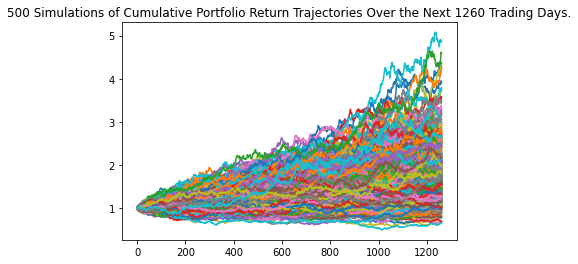

In [146]:
# Plot simulation outcomes
line_plot = MC_5_year_sim.plot_simulation()
# Save the plot
line_plot.get_figure().savefig("MC_5_year_sim_plot.png", bbox_inches="tight")

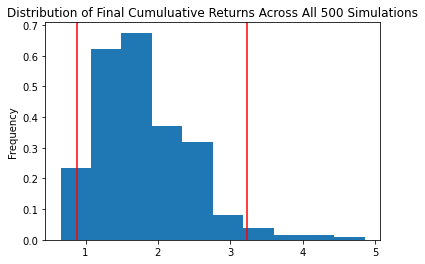

In [147]:
# Plot probability distribution and confidence intervals
dist_plot = MC_5_year_sim.plot_distribution()
# Save the plot
dist_plot.get_figure().savefig("MC_5_year__dist_plot.png", bbox_inches="tight")

In [148]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_5= MC_5_year_sim.summarize_cumulative_return()

# Print summary statistics
print(tbl_5)

count           500.000000
mean              1.804283
std               0.653437
min               0.654345
25%               1.336474
50%               1.690897
75%               2.164981
max               4.860779
95% CI Lower      0.883995
95% CI Upper      3.225100
Name: 1260, dtype: float64


c:\Users\yingf\Documents\homework\Financial-Planner\MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


In [149]:
# Set initial investment increase 3 times.
initial_investment = 20000*3

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(tbl_5[8]*initial_investment,2)
ci_upper_five = round(tbl_5[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $53039.72 and $193506.03


### Ten Years Retirement Option

In [150]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# Based on weights [0.2,0.8]
MC_10_year_sim = MCSimulation(
    portfolio_data = df_portfolio,
    weights=[.2,.8],
    num_simulation = 500,
    num_trading_days = 252*10)

In [151]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10_year_sim.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.980071,0.985413,1.002658,0.995204,0.987109,1.012524,0.987578,0.995127,0.996607,1.011402,...,0.993165,1.019919,0.989516,0.995824,0.984712,1.001077,0.995932,1.019958,0.990874,1.007662
2,0.998772,0.972707,0.978006,0.990754,0.984409,1.019584,0.992648,1.008057,1.000924,1.001639,...,0.996890,1.035109,0.992233,0.999864,0.986002,0.992849,0.992899,1.017279,0.997397,1.011558
3,0.997992,0.967713,0.986922,1.000356,0.991551,1.024317,0.991629,1.000662,1.006414,1.011961,...,1.011800,1.007543,0.991912,1.030052,0.991326,0.977469,0.994798,1.013970,1.003270,1.028323
4,0.998755,0.961687,0.984567,0.989450,0.982728,1.025059,0.986170,0.997799,0.994261,1.024805,...,1.009231,1.008858,0.980952,1.023477,0.984740,0.988450,0.987341,1.027529,1.010048,1.025206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.514491,7.491921,2.249838,1.690732,1.676727,1.535798,0.873679,4.973803,1.645938,6.608709,...,1.615639,1.431962,1.897658,5.322007,2.834796,1.839142,3.221674,6.500802,1.005969,2.538286
2517,1.508714,7.477144,2.238450,1.685696,1.687450,1.542368,0.866988,4.932766,1.643048,6.756181,...,1.645368,1.426426,1.878860,5.304014,2.833569,1.863583,3.165402,6.602271,1.000018,2.534695
2518,1.513716,7.579535,2.269308,1.702564,1.708331,1.535854,0.863309,4.940972,1.626861,6.690951,...,1.641616,1.433673,1.881273,5.334634,2.855754,1.834478,3.160671,6.710984,1.000757,2.533235
2519,1.498062,7.599643,2.227547,1.714441,1.711647,1.532030,0.866286,4.918129,1.618305,6.712536,...,1.661846,1.442923,1.875503,5.418506,2.861296,1.829322,3.207736,6.625441,1.009510,2.544239


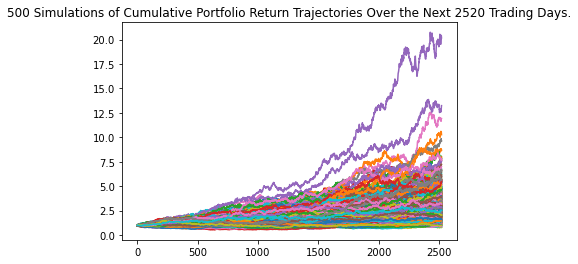

In [152]:
# Plot simulation outcomes
line_plot = MC_10_year_sim.plot_simulation()
# Save the plot
line_plot.get_figure().savefig("MC_10_year_sim_plot.png", bbox_inches="tight")

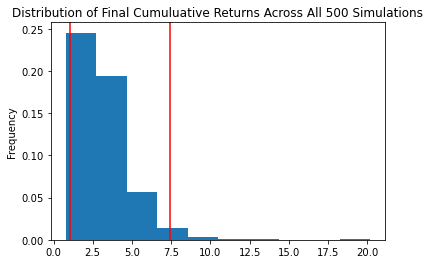

In [153]:
# Plot probability distribution and confidence intervals
dist_plot = MC_10_year_sim.plot_distribution()
# Save the plot
dist_plot.get_figure().savefig("MC_10_year__dist_plot.png", bbox_inches="tight")

In [154]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_10= MC_10_year_sim.summarize_cumulative_return()

# Print summary statistics
print(tbl_10)

count           500.000000
mean              3.140625
std               1.797891
min               0.782800
25%               2.000599
50%               2.774777
75%               3.889657
max              20.182768
95% CI Lower      1.082089
95% CI Upper      7.414937
Name: 2520, dtype: float64


c:\Users\yingf\Documents\homework\Financial-Planner\MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


In [155]:
# Set initial investment 5 times increase
initial_investment = 20000 *5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(tbl_10[8]*initial_investment,2)
ci_upper_ten = round(tbl_10[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $100000 in the portfolio over the next 10 years will end within in the range of $108208.89 and $741493.66
